## Notebook for training GPR on DC dataset and generating set of suggestions

**Created on 10th August, 2023; modified on 14th March, 2024**

**Dataset: label_ecfp_pca_add_feat_082423.csv**

In [1]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
## import train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process.kernels import RBF, ExpSineSquared, RationalQuadratic, WhiteKernel, Matern, ConstantKernel, DotProduct, PairwiseKernel 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.special import erf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import SVG, display

import json
from bokeh.plotting import figure, show, output_notebook, ColumnDataSource
from bokeh.models import HoverTool, ColorBar, CategoricalColorMapper
from bokeh.transform import factor_cmap
from bokeh.plotting import figure, output_file, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Turbo256, d3
import pdb
output_notebook()

Loading BokehJS ...

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-5
total 994872
-rw-r--r--  1 riteshk  staff  506245881 Mar 14 21:40 unlabel_1mil_ecfp_pca_add_feat_iter_4.csv
-rw-r--r--@ 1 riteshk  staff      57647 Mar 14 21:46 label_ecfp_pca_add_feat_iter_4_021824.csv
-rw-r--r--@ 1 riteshk  staff     929164 Mar 14 21:54 Activelearning-batch4.xlsx
-rw-r--r--@ 1 riteshk  staff        165 Mar 14 21:54 ~$Activelearning-batch4.xlsx
-rw-r--r--@ 1 riteshk  staff    2126447 Mar 14 21:56 sugg_gpr_bma_iter_5.ipynb


Finding smiles that have been labeled

In [3]:
df_unlabel = pd.read_csv('../campaign-4/unlabel_1mil_ecfp_pca_add_feat_iter_4.csv') ## unlabeled data created from iteration-4; initial unlabeled data (~1 mil)
df_unlabel.rename(columns={'Unnamed: 0':'index_2'}, inplace=True) ## change index accordingly, but original index is in index_0 column
df_unlabel

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [4]:
def get_row(ind):
    sm = df_unlabel.loc[df_unlabel['index_0'] == ind]['solv_comb_sm']
    return df_unlabel.loc[df_unlabel['solv_comb_sm'] == sm.values[0]]

In [6]:
row_1 = get_row(324220)
row_1

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
324190,324195,324206,324220,CCCOP(=O)(F)OC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.006057,-1.338091,0.687763,0.419938,0.580514,...,0.258767,0.301779,-0.272648,260.0037,186.939685,1.0,0.0,150,50,2
630987,630998,631019,631045,CCCOP(=O)(F)OC(F)(F)C(F)(F)F,[Li+].F[P-](F)(F)(F)(F)F,-1.006057,-1.338091,0.687763,0.419938,0.580514,...,0.195230,0.319099,-0.209425,260.0037,151.980186,1.0,0.0,150,50,2


In [28]:
# sm = Chem.MolFromSmiles('CCCCCCOC=O')
# sm = Chem.MolFromSmiles('CCCCCCOS(=O)(=O)C')
# sm = Chem.MolFromSmiles('CCCCCOCCCCC')
# sm = Chem.MolFromSmiles('CCCCOCCCl')
# sm = Chem.MolFromSmiles('CCCCOCCOCCCC')
# sm = Chem.MolFromSmiles('CCCCOC')
# sm = Chem.MolFromSmiles('CCCCCCON=O')
# sm = Chem.MolFromSmiles('CO[Si](CCC(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F)(F)F)(OC)OC')
sm = Chem.MolFromSmiles('CCCCC(OCC)OCC')
df_unlabel.loc[df_unlabel['solv_comb_sm'] == Chem.MolToSmiles(sm)]

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
265282,265286,265296,265310,CCCCC(OCC)OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,...,0.258767,0.301779,-0.272648,160.14633,186.939685,1.0,0.0,150,50,2
562212,562222,562242,562267,CCCCC(OCC)OCC,[Li+].F[P-](F)(F)(F)(F)F,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,...,0.195230,0.319099,-0.209425,160.14633,151.980186,1.0,0.0,150,50,2
989300,989316,989347,989385,CCCCC(OCC)OCC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,...,0.008496,0.161338,0.109063,160.14633,144.001775,1.0,0.0,150,50,2


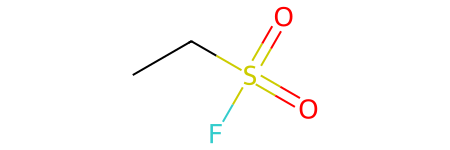

In [110]:
Chem.MolFromSmiles('COCCN(C)S(C)(=O)=O')
Chem.MolFromSmiles('CCS(=O)(=O)F')

In [32]:
## Finding labaled data from 3rd campaign
label_iter_5 = pd.DataFrame(columns=df_unlabel.columns)
## the code below will only extract one solvent entry; but we want all three solvent entries
row_1 = get_row(20811) ## CAS: 629-33-4
row_2 = get_row(227139) ## CAS: 16156-50-6
row_3 = get_row(147255) ## CAS: 693-65-2
row_4 = get_row(28111) ## CAS: 10503-96-5 
row_5 = get_row(108481) ## CAS: 112-48-1 
row_6 = get_row(5684) ## CAS: 628-28-4
row_7 = get_row(49225) ## CAS: 638-51-7
row_8 = get_row(1050) ## CAS: 85857-16-5 
row_9 = get_row(265310) ## CAS: 3658-79-5
label_iter_5 = pd.concat([label_iter_5, row_1, row_2, row_3, row_4, row_5, row_6, row_7, row_8, row_9], axis=0)
label_iter_5
# row_9

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
20806,20807,20808,20811,CCCCCCOC=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.151047,-1.634688,0.371758,1.375369,0.072907,...,0.258767,0.301779,-0.272648,130.099380,186.939685,1.0,0.0,150,50,2
346240,346248,346259,346275,CCCCCCOC=O,[Li+].F[P-](F)(F)(F)(F)F,-1.151047,-1.634688,0.371758,1.375369,0.072907,...,0.195230,0.319099,-0.209425,130.099380,151.980186,1.0,0.0,150,50,2
677265,677276,677297,677324,CCCCCCOC=O,[Li+].O=C1O[B-](F)(F)OC1=O,-1.151047,-1.634688,0.371758,1.375369,0.072907,...,0.008496,0.161338,0.109063,130.099380,144.001775,1.0,0.0,150,50,2
227111,227115,227125,227139,CCCCCCOS(C)(=O)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185309,-1.639031,0.285152,1.403113,0.107494,...,0.258767,0.301779,-0.272648,180.082015,186.939685,1.0,0.0,150,50,2
572813,572823,572843,572868,CCCCCCOS(C)(=O)=O,[Li+].F[P-](F)(F)(F)(F)F,-1.185309,-1.639031,0.285152,1.403113,0.107494,...,0.195230,0.319099,-0.209425,180.082015,151.980186,1.0,0.0,150,50,2
845031,845045,845074,845111,CCCCCCOS(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,-1.185309,-1.639031,0.285152,1.403113,0.107494,...,0.008496,0.161338,0.109063,180.082015,144.001775,1.0,0.0,150,50,2
147236,147239,147246,147255,CCCCCOCCCCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.787099,-1.860123,0.108463,1.068635,-0.232016,...,0.258767,0.301779,-0.272648,158.167065,186.939685,1.0,0.0,150,50,2
445998,446007,446025,446047,CCCCCOCCCCC,[Li+].F[P-](F)(F)(F)(F)F,-0.787099,-1.860123,0.108463,1.068635,-0.232016,...,0.195230,0.319099,-0.209425,158.167065,151.980186,1.0,0.0,150,50,2
807221,807235,807264,807299,CCCCCOCCCCC,[Li+].O=C1O[B-](F)(F)OC1=O,-0.787099,-1.860123,0.108463,1.068635,-0.232016,...,0.008496,0.161338,0.109063,158.167065,144.001775,1.0,0.0,150,50,2
28105,28106,28108,28111,CCCCOCCCl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.744628,-1.849104,0.136047,0.898735,-0.158824,...,0.258767,0.301779,-0.272648,136.065493,186.939685,1.0,0.0,150,50,2


In [33]:
label_iter_5['solv_comb_sm'].unique()

array(['CCCCCCOC=O', 'CCCCCCOS(C)(=O)=O', 'CCCCCOCCCCC', 'CCCCOCCCl',
       'CCCCOCCOCCCC', 'CCCCOC', 'CCCCCCON=O',
       'CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)F)(OC)OC',
       'CCCCC(OCC)OCC'], dtype=object)

In [34]:
df_unlabel_ = df_unlabel.drop(label_iter_5.index) ## drop the labeled molecules from the unlabeled data
df_unlabel_

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type
0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,...,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2
1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,...,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2
2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,...,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2
3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,...,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2
4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,...,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,...,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,0.0,150,50,2
999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,...,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,0.0,150,50,2
999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,...,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,0.0,150,50,2
999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,...,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,0.0,150,50,2


In [35]:
df_unlabel_.to_csv('unlabel_1mil_ecfp_pca_add_feat_iter_5.csv') ## save the unlabeled data for the next iteration
# df_unlabel_ = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat_iter_5.csv') ## read the unlabeled data for the next iteration
# df_unlabel_

In [36]:
label_iter_5.to_csv('just_label_iter_5.csv', index=False) ## also save the labeled data from the 4th iteration of suggestions
# label_iter_5 = pd.read_csv('just_label_iter_5.csv') ## read the labeled data labeled data from the 4th iteration of suggestions
# label_iter_5

In [37]:
df = pd.read_csv('label_ecfp_pca_add_feat_iter_5_031424.csv') ## added the labeled data from the 3rd iteration of suggestions to the labeled data from 2nd iteration manually
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].F[P-](F)(F)(F)(F)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
148,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
149,CCCCC(OCC)OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,-0.032573,-0.282244,-0.394660,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
150,CCCCC(OCC)OCC,[Li+].F[P-](F)(F)(F)(F)F,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,-0.032573,-0.282244,-0.394660,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [38]:
df['theor_capacity'].unique()

array([150, 203, 161])

In [39]:
## Important change: on 24th August, 2023
df_ = df.copy()
df_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].F[P-](F)(F)(F)(F)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
148,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].O=C1O[B-](F)(F)OC1=O,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
149,CCCCC(OCC)OCC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,-0.032573,-0.282244,-0.394660,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
150,CCCCC(OCC)OCC,[Li+].F[P-](F)(F)(F)(F)F,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,-0.032573,-0.282244,-0.394660,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [40]:
X = df_.iloc[:,2:27]
y = df_['norm_capacity_3']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) ## will be using complete dataset for training
# X_test
X

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,90.068080,186.939685,1.0,150,50
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,1.0,150,50
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,146.130680,186.939685,2.2,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,-0.042483,-0.263213,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,468.042638,151.980186,1.0,150,50
148,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,-0.042483,-0.263213,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,468.042638,144.001775,1.0,150,50
149,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,-0.032573,-0.282244,-0.394660,0.180567,-0.037579,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,160.146330,186.939685,1.0,150,50
150,-1.136945,-1.670538,-0.213663,1.023836,-0.449583,-0.032573,-0.282244,-0.394660,0.180567,-0.037579,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,160.146330,151.980186,1.0,150,50


In [41]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

In [42]:
kernel_1 = PairwiseKernel(metric='polynomial') + WhiteKernel(noise_level=0.1)
kernel_3 = RBF(length_scale=0.01) + WhiteKernel(noise_level=0.1)
kernel_2 = Matern(length_scale=0.01, nu=2.5) + WhiteKernel(noise_level=0.1)
kernel_4 = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.1)
kernel_5 = ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernel_6 = RationalQuadratic(length_scale=0.01, alpha=1.0) + WhiteKernel(noise_level=0.1)
kernel_7 = DotProduct(sigma_0=0.1) + WhiteKernel(noise_level=0.1)
kernel_8 = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.1)
kernels = [kernel_1, kernel_2, kernel_3, kernel_4, kernel_5, kernel_6, kernel_7, kernel_8]
kernel_name = ['PairwiseKernel', 'Matern 5/2', 'RBF', 'Matern 3/2', 'ExpSineSquared', 'RationalQuadratic', 'DotProduct', 'RBF+ExpSineSquared']
cv_dict = {'kernel': list(), 'score': list()}

In [43]:
# def negative_log_likelihood(noise_level, length_scale, alpha, kernel_name):
# def negative_log_likelihood(params, kernel_name):
def negative_log_likelihood_rbf(params):
    noise_level, length_scale, alpha = params ## for adding regularization parameter
    # noise_level, length_scale = params ## in case of not adding regularization parameter
    # if kernel_name == 'RBF':
    kernel = RBF(length_scale=length_scale)
    # elif kernel_name == 'Matern-5/2':
        # kernel = Matern(length_scale=length_scale, nu=2.5)
    # elif kernel_name == 'Pairwise':
        # kernel = PairwiseKernel(metric='polynomial')
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    # gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=0.0, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=0) ## in case of not adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rq(params):
    noise_level, length_scale, alpha_k, alpha = params ## for adding regularization parameter
    kernel = RationalQuadratic(length_scale=length_scale, alpha=alpha_k)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_rbf_expsin(params):
    noise_level, length_scale, periodicity, alpha = params ## for adding regularization parameter
    kernel = RBF(length_scale=length_scale) + ExpSineSquared(length_scale=length_scale, periodicity=periodicity)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42) ## for adding regularization parameter
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_matern(params):
    noise_level, length_scale, alpha = params
    kernel = Matern(length_scale=length_scale, nu=1.5)
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

def negative_log_likelihood_pairwise(params):
    noise_level, length_scale, alpha = params
    kernel = PairwiseKernel(metric="polynomial")
    white_kernel = WhiteKernel(noise_level=noise_level)
    composite_kernel = kernel + white_kernel
    gpr = GaussianProcessRegressor(kernel=composite_kernel, alpha=alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
    gpr.fit(X_std, y)
    pred_mean, pred_std = gpr.predict(X_std, return_std=True)
    log_likelihood = np.sum(norm.logpdf(y, loc=pred_mean, scale=pred_std))
    return -log_likelihood

**Optimize Pairwise kernel**

In [44]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_pairwise, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.0001


In [45]:
optimized_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.5770764275966862
MAE: 0.14275048295020262
RMSE: 0.18629359195419157


In [46]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

PairwiseKernel(gamma=0.0008175759995896094, metric=polynomial) + WhiteKernel(noise_level=0.0391)

In [47]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.358913,0.202383
1,0.661460,0.295044,0.203956
2,0.178387,0.333824,0.204810
3,0.216953,0.333824,0.204810
4,0.026187,0.456053,0.211715
...,...,...,...
147,0.000000,0.048132,0.222980
148,0.000000,0.024261,0.227358
149,0.000000,0.057926,0.207778
150,0.000000,-0.096373,0.209774


**Optimize RationalQuadratic kernel**

In [48]:
initial_guess = [0.15, 0.01, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha_k, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha_k, alpha
result = minimize(negative_log_likelihood_rq, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha_k, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha_k:", optimized_alpha_k)
print("Optimized alpha:", optimized_alpha)

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha_k: 0.006863724867378534
Optimized alpha: 0.01375256505111782


In [49]:
optimized_kernel = RationalQuadratic(length_scale=optimized_length_scale, alpha=optimized_alpha_k) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.8566144947526313
MAE: 0.06895000558100253
RMSE: 0.10847248660727682


In [50]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RationalQuadratic(alpha=0.00919, length_scale=5.5) + WhiteKernel(noise_level=0.00777)

In [51]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.294366,0.119928
1,0.661460,0.362897,0.125020
2,0.178387,0.283993,0.119294
3,0.216953,0.283993,0.119294
4,0.026187,0.178173,0.143098
...,...,...,...
147,0.000000,0.023706,0.148342
148,0.000000,0.014844,0.149286
149,0.000000,0.077603,0.141557
150,0.000000,0.012894,0.143538


**Optimize Matern-3/2 kernel**

In [52]:
initial_guess = [0.15, 0.01, 0.02] # initial guess for noise_level, length_scale, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, alpha
result = minimize(negative_log_likelihood_matern, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized alpha:", optimized_alpha)

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized alpha: 0.008408402870819119


In [53]:
optimized_kernel = Matern(length_scale=optimized_length_scale, nu=1.5) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.6498279172011101
MAE: 0.11940266958053011
RMSE: 0.16951484237490158


In [54]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

Matern(length_scale=30.2, nu=1.5) + WhiteKernel(noise_level=0.0264)

In [55]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.353833,0.170717
1,0.661460,0.297031,0.172406
2,0.178387,0.327738,0.173590
3,0.216953,0.327738,0.173590
4,0.026187,0.431276,0.185235
...,...,...,...
147,0.000000,0.006985,0.203263
148,0.000000,-0.007710,0.209735
149,0.000000,0.064927,0.180236
150,0.000000,-0.063836,0.185377


**Optimize RBF-ExpineSquared kernel**

In [56]:
initial_guess = [0.15, 0.01, 1.0, 0.02] # initial guess for noise_level, length_scale, periodicity, alpha
param_bounds = [(1e-4, 1.0), (1e-5, 50.0), (1e-2, 10.0), (1e-4, 0.1)] # bounds for noise_level, length_scale, periodicity, alpha
result = minimize(negative_log_likelihood_rbf_expsin, initial_guess, bounds=param_bounds)
optimized_hyperparameters = result.x
optimized_noise_level, optimized_length_scale, optimized_periodicity, optimized_alpha = optimized_hyperparameters
print("Optimized noise_level:", optimized_noise_level)
print("Optimized length_scale:", optimized_length_scale)
print("Optimized periodicity:", optimized_periodicity)
print("Optimized alpha:", optimized_alpha)

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Optimized noise_level: 0.15
Optimized length_scale: 0.01
Optimized periodicity: 1.0
Optimized alpha: 0.020000000201304317


In [57]:
optimized_kernel = RBF(length_scale=optimized_length_scale) + ExpSineSquared(length_scale=optimized_length_scale, periodicity=optimized_periodicity) + WhiteKernel(noise_level=optimized_noise_level)
gpr_optimized = GaussianProcessRegressor(kernel=optimized_kernel, alpha=optimized_alpha, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)
gpr_optimized.fit(X_std, y)
y_pred, y_uncer = gpr_optimized.predict(X_std, return_std=True)
print("R2 score:", r2_score(y, y_pred))
print("MAE:", mean_absolute_error(y, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y, y_pred)))

R2 score: 0.6115702750894627
MAE: 0.13172302223674787
RMSE: 0.17853493061858317


In [58]:
gpr_optimized.get_params()
gpr_optimized.log_marginal_likelihood(gpr_optimized.kernel_.theta)
gpr_optimized.kernel_

RBF(length_scale=16.9) + ExpSineSquared(length_scale=94, periodicity=0.00119) + WhiteKernel(noise_level=0.018)

In [59]:
pred_df = pd.DataFrame({'y': y, 'y_pred': y_pred, 'y_uncer': y_uncer})
pred_df

,y,y_pred,y_uncer
0,0.276580,0.356971,0.142138
1,0.661460,0.305105,0.144567
2,0.178387,0.328821,0.145528
3,0.216953,0.328821,0.145528
4,0.026187,0.465883,0.157208
...,...,...,...
147,0.000000,0.020237,0.176340
148,0.000000,-0.007553,0.184962
149,0.000000,0.045988,0.151247
150,0.000000,-0.095971,0.155521


**Production runs**

In [60]:
# df_unlabel = pd.read_csv('unlabel_1mil_ecfp_pca_add_feat.csv')
# df_unlabel_ = df_unlabel.copy()
df_unlabel_.drop(['conc_salt_2', 'pressure_type'], axis=1, inplace=True) ## dropping 'conc_salt_2' and 'pressure_type' columns as I think may not be that important
df_unlabel_

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,193.077264,144.001775,1.0,150,50
999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,240.147392,144.001775,1.0,150,50
999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,251.046358,144.001775,1.0,150,50
999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,248.133634,144.001775,1.0,150,50


In [61]:
# uniq_smiles = df_unlabel_['smiles'].unique()
df_unlabel_uniq = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
df_unlabel_uniq

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,73.052764,186.939685,1.0,150,50
1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,114.079313,186.939685,1.0,150,50
2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,116.094963,186.939685,1.0,150,50
3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,70.058995,186.939685,1.0,150,50
4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,72.044939,186.939685,1.0,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999899,999915,999946,999984,CCCCN1C(=O)OCC1[SiH](C)C,[Li+].O=C1O[B-](F)(F)OC1=O,0.627609,-0.998588,-0.085111,1.419019,0.429198,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,201.118505,144.001775,1.0,150,50
999901,999917,999948,999986,CC(C)(C)C(=O)N1C2CCC1COC2,[Li+].O=C1O[B-](F)(F)OC1=O,0.902927,0.033572,0.856049,-0.034590,1.299159,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,197.141579,144.001775,1.0,150,50
999902,999918,999949,999987,CC(C)(C)C(=O)CS(=O)(=O)CC(=O)N1CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.621175,0.407378,0.570353,0.639576,1.375775,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,275.119129,144.001775,1.0,150,50
999903,999919,999950,999988,CCO[Si](CCC(C)SC)(OC)OC,[Li+].O=C1O[B-](F)(F)OC1=O,-1.112749,-1.140740,0.140488,-0.169667,-0.945768,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,238.105892,144.001775,1.0,150,50


In [63]:
# df_unlabel_.drop(columns=['Unnamed: 0'], inplace=True)
X_un = df_unlabel_.iloc[:,5:] ## change it for every new iteration
X_un_std = std_scale_.transform(X_un)
X_un_std = pd.DataFrame(X_un_std, columns=X_un.columns)
# X_std = std_scale_.transform(X)
# X_std = pd.DataFrame(X_std, columns=X.columns)
X_un_std

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,0.171619,0.693008,-2.175094,-0.241159,1.806673,-0.411073,-0.740639,0.045689,-1.477644,0.298156,...,0.387326,-0.689261,0.587024,0.407837,-0.541330,-1.385075,0.479508,-0.300363,-0.307567,0.227391
1,1.841040,0.806199,0.067311,1.460788,1.277634,-2.403548,-0.248003,1.529708,-1.507852,0.252774,...,0.387326,-0.689261,0.587024,0.407837,-0.541330,-0.705319,0.479508,-0.300363,-0.307567,0.227391
2,-0.135093,2.949999,-1.805432,-0.193351,2.560854,-0.612129,-0.914093,-0.070920,-1.453902,0.343682,...,0.387326,-0.689261,0.587024,0.407837,-0.541330,-0.671922,0.479508,-0.300363,-0.307567,0.227391
3,0.386513,-0.216419,-0.090397,0.160073,1.376062,-1.045680,-0.659099,-0.254082,-2.055942,0.324623,...,0.387326,-0.689261,0.587024,0.407837,-0.541330,-1.434678,0.479508,-0.300363,-0.307567,0.227391
4,0.224074,0.790168,-2.264155,-0.510123,1.844909,-0.707377,-0.715417,0.155675,-1.560660,0.292664,...,0.387326,-0.689261,0.587024,0.407837,-0.541330,-1.401773,0.479508,-0.300363,-0.307567,0.227391
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999882,1.538220,0.332545,-0.242531,0.670365,1.137994,-1.545214,-0.592032,0.002690,-2.513284,1.890402,...,-2.109564,1.756257,-2.123402,-2.127893,2.149078,0.603573,-1.306400,-0.300363,-0.307567,0.227391
999883,1.676245,4.183613,2.604196,0.809342,0.124133,-1.012858,-0.833220,3.040371,1.900327,-1.077632,...,-2.109564,1.756257,-2.123402,-2.127893,2.149078,1.383463,-1.306400,-0.300363,-0.307567,0.227391
999884,1.450908,4.100602,1.805046,1.581449,-0.220540,-0.253687,-0.026441,-1.218321,-0.641951,1.372231,...,-2.109564,1.756257,-2.123402,-2.127893,2.149078,1.564044,-1.306400,-0.300363,-0.307567,0.227391
999885,1.273003,4.780632,-2.085018,-0.798604,1.418824,1.468240,-1.337359,-0.078720,0.383267,-0.493036,...,-2.109564,1.756257,-2.123402,-2.127893,2.149078,1.515784,-1.306400,-0.300363,-0.307567,0.227391


In [64]:
## final corrected & verified one to be used
def EI_(y_pred, y_pred_un, y_pred_un_uncer, epsilon=0.01):
    y_best = np.max(y_pred)
    EI = []

    for i in range(len(y_pred_un)):
        if y_pred_un_uncer[i] != 0:
            # Calculate the cumulative distribution function (CDF) for the Gaussian distribution
            z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            # z = (y_pred_un[i] - y_best - epsilon) / y_pred_un_uncer[i]
            cdf_z = 0.5 * (1 + erf(z / np.sqrt(2)))
            pdf_z = np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

            # Calculate the probability of improvement
            # probability_improvement = y_pred_un_uncer[i] * (z * cdf_z + np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi))

            # Calculate Expected Improvement
            expected_improvement = y_pred_un_uncer[i] * (z * cdf_z) + y_pred_un_uncer[i] * pdf_z
            EI.append(expected_improvement)
        else:
            EI.append(0.0)
    return EI

**Bayesian model averaging (BMA)**

In [65]:
## change all hyperparameters accordingly
optimized_pairwise_kernel = PairwiseKernel(metric="polynomial") + WhiteKernel(noise_level=0.15)
optimized_matern_kernel = Matern(length_scale=0.01, nu=1.5) + WhiteKernel(noise_level=0.15)
optimized_rbfexpsin_kernel = RBF(length_scale=0.01) + ExpSineSquared(length_scale=0.01, periodicity=1.0) + WhiteKernel(noise_level=0.15)
optimized_rq_kernel = RationalQuadratic(length_scale=0.01, alpha=0.01375256505111782) + WhiteKernel(noise_level=0.15)
# kernels = [RBF(length_scale=1.0), Matern(length_scale=1.0, nu=1.5)]
gpr_models = [GaussianProcessRegressor(kernel=optimized_pairwise_kernel, alpha=0.0001, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_matern_kernel, alpha=0.008408402870819119, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rq_kernel, alpha=0.006863724867378534, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42),
              GaussianProcessRegressor(kernel=optimized_rbfexpsin_kernel, alpha=0.020000000201304317, optimizer="fmin_l_bfgs_b", n_restarts_optimizer=10, random_state=42)]

k = 0
for model in gpr_models:
    print("fitting model: ", k)
    model.fit(X_std, y)
    k += 1

fitting model:  0
fitting model:  1
fitting model:  2
fitting model:  3


In [66]:
# Calculate Model Weights using BMA (first order)
model_names = ['pairwise_iter5_031424.pkl', 'matern_iter5_031424.pkl', 'rq_iter5_031424.pkl', 'rbfexpsin_iter5_031424.pkl']
model_weights = []
uncertainties = []
predictions = []
y_label_preds = []
for model in gpr_models:
    y_un = model.predict(X_un_std)
    predictions.append(y_un)
    individual_uncertainties = model.predict(X_un_std, return_std=True)[1]
    uncertainties.append(individual_uncertainties)
    likelihoods = norm.pdf(y_un, loc=model.predict(X_un_std), scale=individual_uncertainties)
    prior_beliefs = 1.0  # Non-informative prior
    posterior = likelihoods * prior_beliefs
    model_weights.append(posterior / np.sum(posterior))
    y_ = model.predict(X_std)
    y_label_preds.append(y_)

# Step 4: Calculate Combined Predictions using Model Weights
combined_predictions = np.zeros_like(y_un)
for i, model in enumerate(gpr_models):
    combined_predictions += model.predict(X_un_std) * model_weights[i]
    pickle.dump(model, open(model_names[i], 'wb'))

# Step 5: Select Most Informative Data Points
# informative_indices = np.argsort(combined_predictions)[-num_samples_to_label:]

# Label the selected data points and add them to the labeled set
# labeled_X = X_un_std[informative_indices]
# labeled_y = y_un[informative_indices]
# X_labeled = np.vstack((X_std, labeled_X))
# y_labeled = np.hstack((y, labeled_y))

# # Remove the labeled data points from the unlabeled pool
# # X_unlabeled = np.delete(X_un_std, informative_indices, axis=0)
# # y_unlabeled = np.delete(y_un, informative_indices, axis=0)

# # Retrain GPR models using updated labeled set
# for model in gpr_models:
#     model.fit(X_labeled, y_labeled)

In [67]:
combined_uncertainties = np.sqrt(np.sum((np.array(uncertainties) * np.array(model_weights)) ** 2, axis=0))
combined_uncertainties

array([4.39677956e-07, 4.39677956e-07, 4.39677956e-07, ...,
       4.39677956e-07, 4.39677956e-07, 4.39677956e-07])

In [68]:
# model_weights
combined_predictions
min(individual_uncertainties)
# individual_uncertainties
uncertainties
max(uncertainties[3])
# min(uncertainties[2])

0.41619437372300633

In [69]:
df_unlabel_['norm_capacity_3_pred'] = combined_predictions
df_unlabel_['norm_capacity_3_uncer'] = combined_uncertainties
df_unlabel_['norm_capacity_3_pair'] = predictions[0]
df_unlabel_['norm_capacity_3_un_pair'] = uncertainties[0]
df_unlabel_['norm_capacity_3_matern'] = predictions[1]
df_unlabel_['norm_capacity_3_un_matern'] = uncertainties[1]
df_unlabel_['norm_capacity_3_rq'] = predictions[2]
df_unlabel_['norm_capacity_3_un_rq'] = uncertainties[2]
df_unlabel_['norm_capacity_3_rbfexpsin'] = predictions[3]
df_unlabel_['norm_capacity_3_un_rbfexpsin'] = uncertainties[3]
df_unlabel_['EI_pair'] = EI_(y_label_preds[0], predictions[0], uncertainties[0])
df_unlabel_['EI_matern'] = EI_(y_label_preds[1], predictions[1], uncertainties[1])
df_unlabel_['EI_rq'] = EI_(y_label_preds[2], predictions[2], uncertainties[2])
df_unlabel_['EI_rbfexpsin'] = EI_(y_label_preds[3], predictions[3], uncertainties[3])
df_unlabel_['EI_aggr'] = df_unlabel_['EI_pair']*model_weights[0] + df_unlabel_['EI_matern']*model_weights[1] + df_unlabel_['EI_rq']*model_weights[2] + df_unlabel_['EI_rbfexpsin']*model_weights[3]
df_unlabel_

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
0,0,0,0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,...,0.193493,0.179065,0.212480,-0.025667,0.164752,2.012891e-07,4.640716e-07,0.000826,1.735931e-10,8.861567e-10
1,1,1,1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,...,0.202140,0.119045,0.219109,0.073796,0.173667,2.905744e-06,2.836005e-06,0.000461,2.332214e-08,4.851460e-10
2,2,2,2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,...,0.210576,0.110863,0.225608,-0.104950,0.182416,1.457664e-07,5.046273e-07,0.000529,3.846077e-10,5.344304e-10
3,3,3,3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,...,0.184191,0.217880,0.202245,0.122123,0.155830,3.161428e-06,3.228735e-06,0.000981,5.780023e-09,1.111225e-09
4,4,4,4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,...,0.196940,0.171711,0.215767,-0.047058,0.167827,2.026492e-07,5.468666e-07,0.000841,1.537768e-10,8.878854e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999909,999925,999956,999994,CC1ON(C)C(C)C1S(C)(=O)=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.771012,-1.078565,0.565077,0.216605,0.613562,...,0.224409,0.021469,0.230962,-0.200119,0.195641,2.272285e-08,2.583391e-07,0.000188,2.146709e-10,1.859834e-10
999910,999926,999957,999995,COC(=O)C1(N2CCCN(C)C2=O)CCCC1,[Li+].O=C1O[B-](F)(F)OC1=O,0.881747,0.625623,1.808971,0.306581,0.123581,...,0.242859,0.022475,0.238193,-0.005981,0.217099,2.582878e-06,1.181789e-05,0.000260,5.522743e-07,2.625317e-10
999911,999927,999958,999996,COC(=O)N1CCC(OS(C)(=O)=O)CC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.700964,0.588889,1.459777,0.806459,-0.042994,...,0.251093,0.035219,0.241591,-0.083214,0.223274,1.087033e-06,1.000444e-05,0.000354,1.914942e-07,3.431756e-10
999912,999928,999959,999997,CN(C)C(=O)CN(C)C(=O)C1CCCC1(F)F,[Li+].O=C1O[B-](F)(F)OC1=O,0.558235,0.889818,-0.240008,-0.734436,0.749283,...,0.255512,0.007873,0.241669,-0.281908,0.228976,1.270278e-08,1.640627e-06,0.000246,3.816235e-09,2.331534e-10


In [70]:
max(model_weights[0])
# min(combined_uncertainties)
# max(combined_uncertainties)
# min(df_unlabel_['EI_aggr'])

1.175998858997944e-06

In [71]:
df_unlabel_.to_csv('preds_uncer_ei_unlabel_1mil_iter5_031424.csv', index=False) ## saving predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_ = pd.read_csv('preds_uncer_ei_unlabel_1mil_iter5_031424.csv') ## reading predictions for the unlabeled data (for 4th set of suggestions)
# df_unlabel_

In [72]:
df_new = df_unlabel_.copy()
df_new.sort_values(by=['EI_aggr'], ascending=False, inplace=True) ## sorting in descending order of EI_aggr => df_new is the dataframe that is sorted according to the EI_aggr
df_new_ = df_new.iloc[:100,:]
df_new_

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
223368,223372,223382,223396,COCCOCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.020865,-1.124835,1.256503,-0.548366,0.183966,...,0.168702,0.615736,0.140188,0.453617,0.140688,0.000292,0.000912,0.035307,2.106692e-05,5.889687e-08
193870,193873,193882,193894,COCCOCCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.995461,-1.139384,1.208259,-0.557954,0.205390,...,0.168544,0.606672,0.142112,0.445615,0.140835,0.000266,0.000836,0.032798,1.722846e-05,5.396801e-08
168835,168838,168846,168856,COCCOC(F)(F)C(F)(F)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.960369,-1.072072,1.171623,-0.571801,0.219191,...,0.167280,0.576239,0.146602,0.396499,0.139452,0.000136,0.000412,0.024956,3.683960e-06,3.946021e-08
114081,114084,114090,114099,COCCOC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.940285,-1.074828,1.189192,-0.563295,0.208841,...,0.167200,0.573702,0.146147,0.404751,0.139288,0.000150,0.000448,0.024112,4.616251e-06,3.833149e-08
197889,197892,197901,197913,COCCOCCOC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.994229,-1.119352,1.206267,-0.557097,0.156734,...,0.168944,0.557053,0.151053,0.439425,0.140909,0.000245,0.000711,0.021442,1.466821e-05,3.355010e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165135,165138,165146,165156,COCC(COC)(COC)COP,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.709302,-1.406380,1.012961,-0.632014,0.122775,...,0.168494,0.482914,0.161278,0.310898,0.139780,0.000029,0.000069,0.010659,2.545074e-07,1.516978e-08
330424,330430,330441,330455,COCCCC(Cl)(Cl)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.037912,-1.653221,1.019062,-0.386838,0.013395,...,0.172514,0.442052,0.185210,0.475337,0.143632,0.000453,0.001186,0.010498,4.779249e-05,1.501470e-08
296276,296281,296291,296305,COCCCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.990142,-1.584333,1.023410,-0.404918,0.094915,...,0.171390,0.449623,0.180297,0.462261,0.142910,0.000342,0.000970,0.010419,3.231967e-05,1.484863e-08
146003,146006,146013,146022,COCC(COC)(COP(C)C)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703399,-1.441717,0.985850,-0.692010,0.211349,...,0.168789,0.478709,0.162007,0.306768,0.140153,0.000029,0.000068,0.010269,2.344085e-07,1.455136e-08


In [127]:
# df_new_.to_csv('top100_sugg_ei_test2.csv', index=False)

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_85537/3389624811.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/rdkit/Chem/PandasTools.py:379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].m

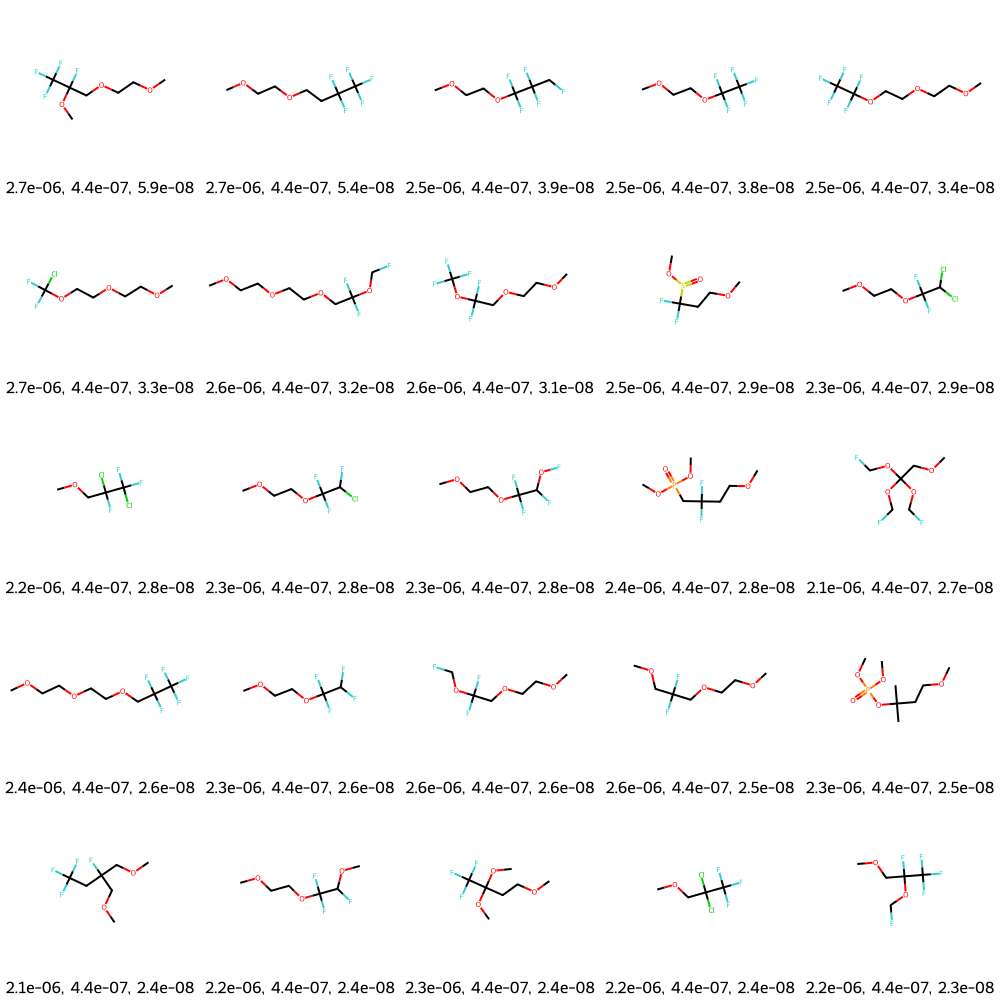

In [73]:
# df_new_['pred_uncertainty'] = df_new_.apply(lambda x: str(round(x['norm_capacity_3_pred'],3)) + ', ' + str(round(x['norm_capacity_3_uncer'],3)) + ', ' + str(round(x['EI_weight_av'],3)), axis=1)
df_new_['pred_comb'] = df_new_.apply(lambda x: str(format(x['norm_capacity_3_pred'],".1e")) + ', ' + str(format(x['norm_capacity_3_uncer'],".1e")) + ', ' + str(format(x['EI_aggr'],".1e")), axis=1)
PandasTools.AddMoleculeColumnToFrame(df_new_, smilesCol='solv_comb_sm')
# PandasTools.FrameToGridImage(df_, legendsCol="norm_capacity_3_pred", molsPerRow=6)
PandasTools.FrameToGridImage(df_new_.iloc[:25], legendsCol="pred_comb", molsPerRow=5)

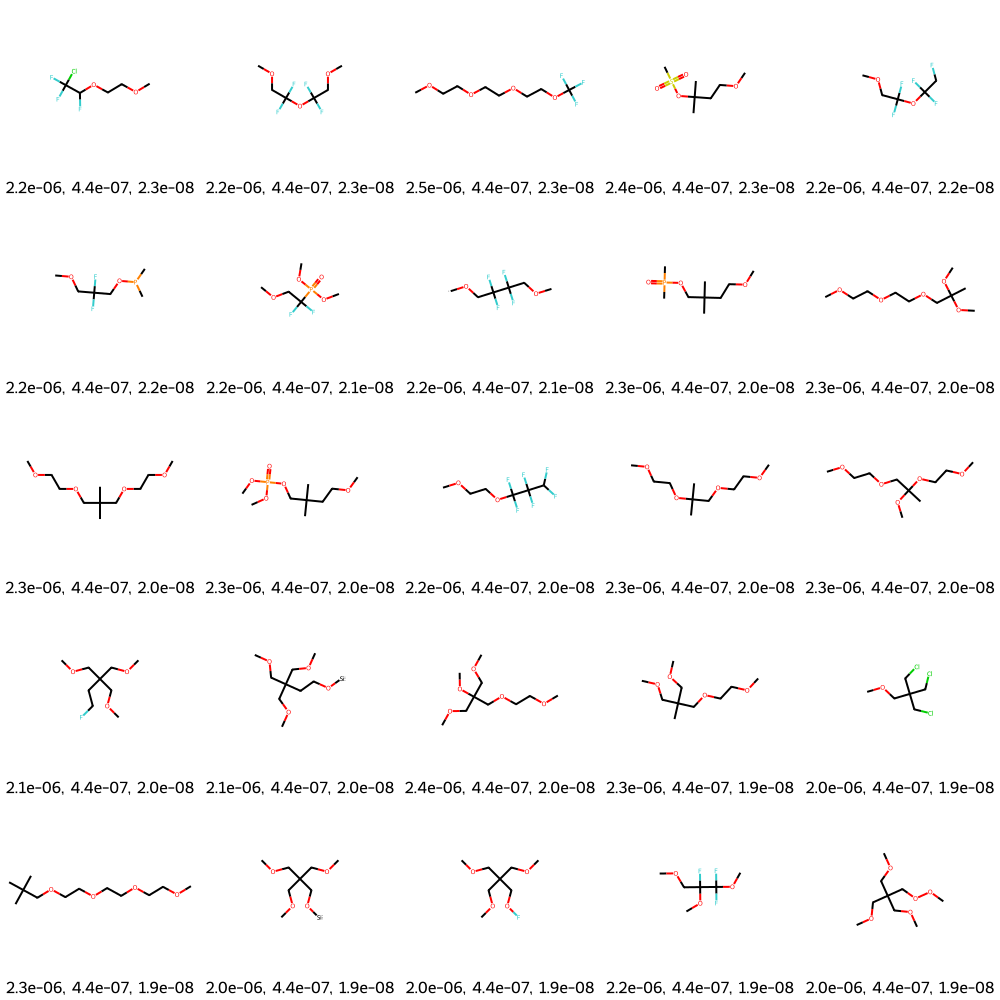

In [74]:
PandasTools.FrameToGridImage(df_new_.iloc[25:50], legendsCol="pred_comb", molsPerRow=5)

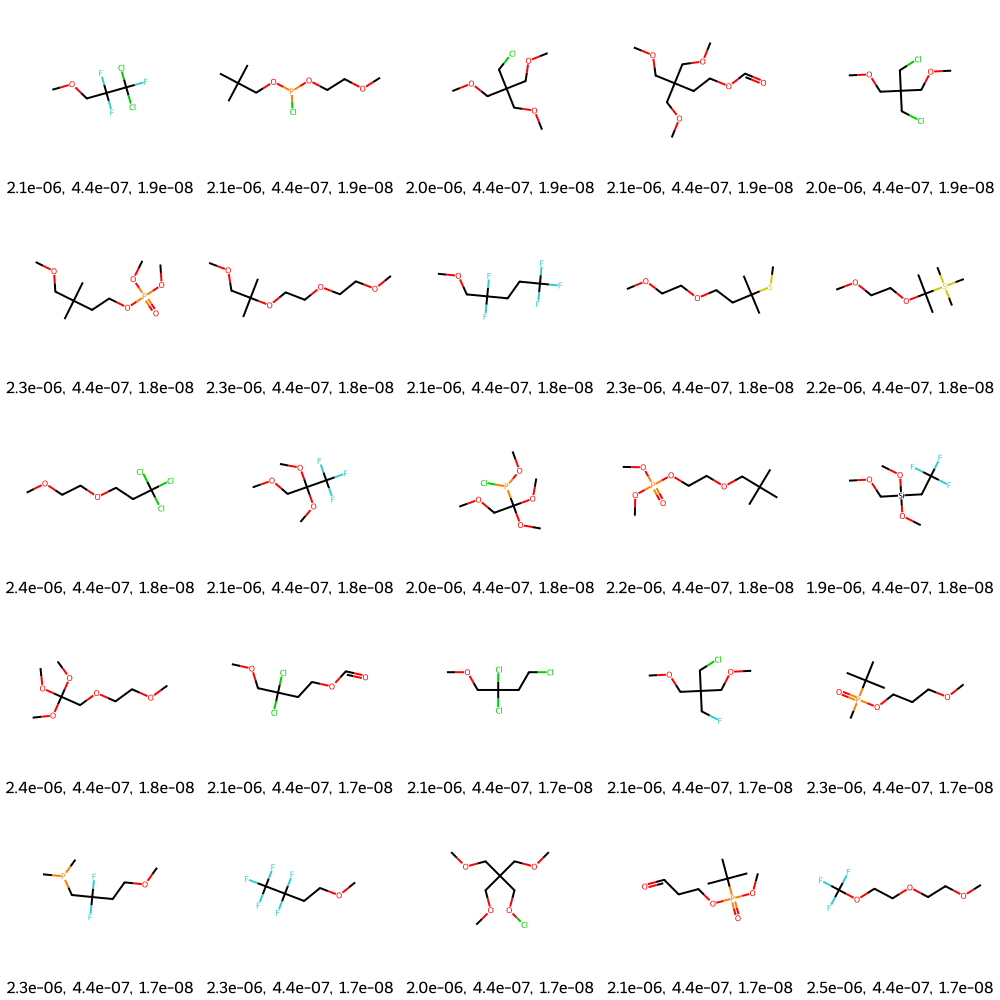

In [75]:
PandasTools.FrameToGridImage(df_new_.iloc[50:75], legendsCol="pred_comb", molsPerRow=5)

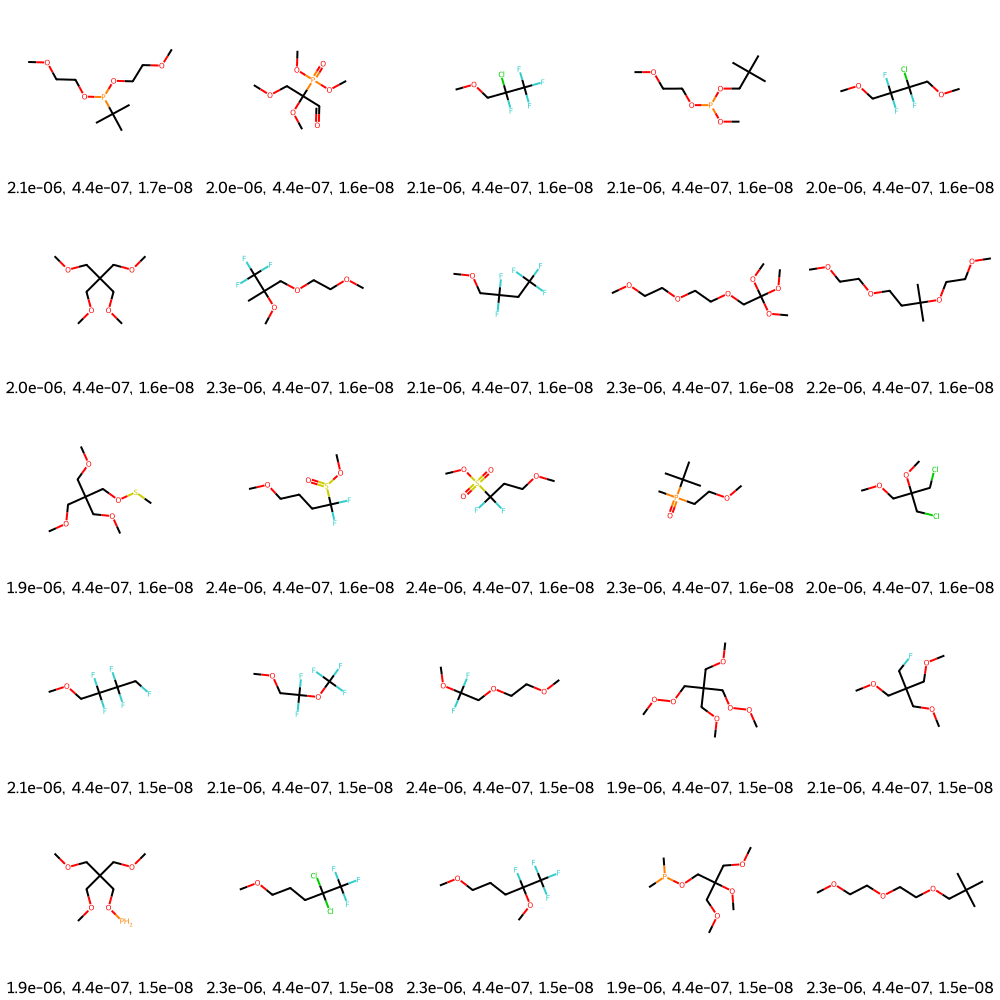

In [76]:
PandasTools.FrameToGridImage(df_new_.iloc[75:100], legendsCol="pred_comb", molsPerRow=5)

In [77]:
%%bash
ls -ltr

total 2609096
-rw-r--r--  1 riteshk  staff  513120525 Mar 14 22:30 unlabel_1mil_ecfp_pca_add_feat_iter_5.csv
-rw-r--r--@ 1 riteshk  staff      13933 Mar 14 22:36 just_label_iter_5.csv
-rw-r--r--@ 1 riteshk  staff     929862 Mar 14 22:54 Activelearning-batch4.xlsx
-rw-r--r--@ 1 riteshk  staff      65846 Mar 14 23:31 label_ecfp_pca_add_feat_iter_5_031424.csv
-rw-r--r--  1 riteshk  staff     222057 Mar 14 23:44 pairwise_iter5_031424.pkl
-rw-r--r--  1 riteshk  staff     222032 Mar 14 23:44 matern_iter5_031424.pkl
-rw-r--r--  1 riteshk  staff     222089 Mar 14 23:44 rq_iter5_031424.pkl
-rw-r--r--  1 riteshk  staff     222218 Mar 14 23:44 rbfexpsin_iter5_031424.pkl
-rw-r--r--  1 riteshk  staff  818807853 Mar 14 23:45 preds_uncer_ei_unlabel_1mil_iter5_031424.csv
-rw-r--r--@ 1 riteshk  staff    1999616 Mar 14 23:46 sugg_gpr_bma_iter_5.ipynb


**tSNE for top 5000**

In [78]:
df_new_5000 = df_new.iloc[:5000,:]
df_new_5000

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,norm_capacity_3_un_matern,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr
223368,223372,223382,223396,COCCOCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.020865,-1.124835,1.256503,-0.548366,0.183966,...,0.168702,0.615736,0.140188,0.453617,0.140688,0.000292,0.000912,0.035307,2.106692e-05,5.889687e-08
193870,193873,193882,193894,COCCOCCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.995461,-1.139384,1.208259,-0.557954,0.205390,...,0.168544,0.606672,0.142112,0.445615,0.140835,0.000266,0.000836,0.032798,1.722846e-05,5.396801e-08
168835,168838,168846,168856,COCCOC(F)(F)C(F)(F)CF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.960369,-1.072072,1.171623,-0.571801,0.219191,...,0.167280,0.576239,0.146602,0.396499,0.139452,0.000136,0.000412,0.024956,3.683960e-06,3.946021e-08
114081,114084,114090,114099,COCCOC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.940285,-1.074828,1.189192,-0.563295,0.208841,...,0.167200,0.573702,0.146147,0.404751,0.139288,0.000150,0.000448,0.024112,4.616251e-06,3.833149e-08
197889,197892,197901,197913,COCCOCCOC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.994229,-1.119352,1.206267,-0.557097,0.156734,...,0.168944,0.557053,0.151053,0.439425,0.140909,0.000245,0.000711,0.021442,1.466821e-05,3.355010e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299283,299288,299298,299312,COCCCN1CC(C(=O)OC)CN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.165869,0.577440,1.601270,0.990103,-0.790383,...,0.236724,0.156933,0.236388,0.208996,0.208136,0.000110,0.000144,0.001359,1.973344e-05,1.567991e-09
90992,90995,91001,91007,O=CCCOCC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.761275,-1.277479,0.779067,-0.404932,0.827255,...,0.174774,0.264166,0.189662,0.308915,0.146374,0.000040,0.000054,0.001210,6.131009e-07,1.567989e-09
64995,64997,65001,65006,COS(=O)(=O)C(C)(F)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.752228,-1.142228,1.152531,-0.551660,1.038829,...,0.176952,0.248299,0.197464,0.287852,0.147902,0.000041,0.000045,0.001270,3.918086e-07,1.567960e-09
320229,320234,320245,320259,CCOS(C)(OC)OC(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.867773,-1.397806,0.719660,-0.257534,0.447464,...,0.170328,0.281195,0.183570,0.237142,0.140498,0.000008,0.000009,0.001248,2.130272e-08,1.567851e-09


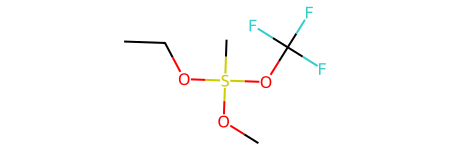

In [81]:
# Chem.MolFromSmiles('COC(C)C(C)(P(=O)(OC)OC)P(=O)(OC)OC')
# Chem.MolFromSmiles('COS(C)(OC)N(C)CC(C)(F)F')
Chem.MolFromSmiles('COCCCCC1C(=O)N(C)C(=O)N(C)C1=O')
Chem.MolFromSmiles('CCOS(C)(OC)OC(F)(F)F')

In [ ]:
# df_unlabel_uniq_ = df_unlabel_.drop_duplicates(subset=['solv_comb_sm'], keep='first')
# df_unlabel_uniq_

In [82]:
df_comb_tsne = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,-0.272648,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,-0.272648,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,-0.272648,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,-0.272648,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,-0.272648,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,-0.272648,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,-0.272648,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414


In [83]:
list_suggest_bool = df_comb_tsne['solv_comb_sm'].isin(df_new_5000['solv_comb_sm'])
sugg_ind = [i for i in range(len(list_suggest_bool)) if list_suggest_bool[i] == True]
list_label_pool = df_comb_tsne['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
# sugg_ind_1 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2))]
# sugg_ind_2 = [sugg_ind[i] for i in range(int(len(sugg_ind)/2), len(sugg_ind))]
df_comb_tsne['database'] = 'unlabel'
# df_comb_tsne.loc[sugg_ind_1, 'database'] = 'sugg_5th_peiyuan'
# df_comb_tsne.loc[sugg_ind_2, 'database'] = 'sugg_5th_ritesh'
df_comb_tsne.loc[sugg_ind, 'database'] = 'sugg_all'
df_comb_tsne.loc[label_ind, 'database'] = 'label'
df_comb_tsne

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


In [84]:
len(sugg_ind)
# sugg_ind
df_comb_tsne['database'].unique()

array(['unlabel', 'sugg_all', 'label'], dtype=object)

cluster regions rather than assigning randomly

In [85]:
df_comb_tsne_sugg = df_comb_tsne.loc[df_comb_tsne['database'] == 'sugg_all']
X_comb_tsne = df_comb_tsne_sugg.iloc[:,-3:-1]
X_comb_tsne

,TSNE_0,TSNE_1
655,1.736852,34.990818
735,-20.417168,-4.034942
1270,28.963886,-15.445543
1342,4.850382,-31.036777
1505,28.953089,-15.437433
...,...,...
333015,-0.766276,17.074923
333072,21.531021,31.725594
333097,-9.002964,-38.695023
333101,-4.642074,-31.186098


In [86]:
kmeans = KMeans(random_state=0).fit(X_comb_tsne) ## using # of clusters found by kmeans method

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

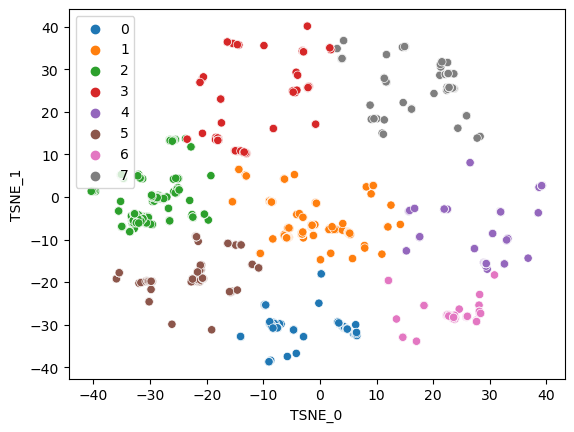

In [87]:
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

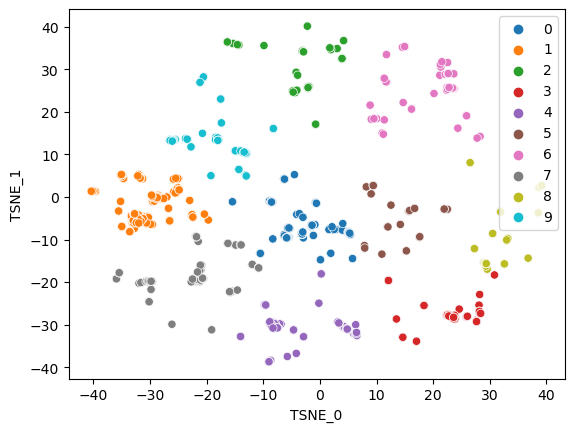

In [88]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_comb_tsne) ## fixing # of clusters to 10
sns.scatterplot(x=df_comb_tsne_sugg['TSNE_0'], y=df_comb_tsne_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [89]:
row_label = df_comb_tsne.loc[df_comb_tsne['database'] == 'label']
df_comb_tsne_sugg['database'] = [('sugg_5th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_comb_tsne_ = pd.concat([row_label, df_comb_tsne_sugg], axis=0)
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_85537/769887304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_comb_tsne_sugg['database'] = [('sugg_5th_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,468.042638,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,99.104799,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,99.104799,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,88.088815,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,74.073165,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333015,CCC(=O)CC(CCOC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.451813,-0.194807,0.881349,0.225478,-0.903288,-0.207091,0.387309,0.198267,...,174.125594,186.939685,1.0,0.0,150,50,2,-0.766276,17.074923,sugg_5th_2
333072,FCCOCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.645508,-1.686106,0.770590,-0.476692,0.716019,-0.145151,0.818991,0.095029,...,196.032284,186.939685,1.0,0.0,150,50,2,21.531021,31.725594,sugg_5th_6
333097,COCOCOP=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.599196,-0.969392,0.889094,-0.231780,-0.288586,0.057383,0.397675,0.209634,...,138.008195,186.939685,1.0,0.0,150,50,2,-9.002964,-38.695023,sugg_5th_4
333101,COCCOCCOCC(=O)OCC(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.660152,0.037751,1.085719,-0.276596,-0.883826,-0.435727,0.325705,0.298334,...,234.146724,186.939685,1.0,0.0,150,50,2,-4.642074,-31.186098,sugg_5th_4


In [91]:
df_new_5000['rank'] = [i for i in range(1,5001)]
df_comb_tsne_ = df_comb_tsne_.merge(df_new_5000[['solv_comb_sm', 'salt_comb_sm', 'rank']], on=['solv_comb_sm', 'salt_comb_sm'], how='left')
df_comb_tsne_

/var/folders/s5/lmr5dh0n4bsgnpxrzwlts5lw0000gn/T/ipykernel_85537/694021055.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_5000['rank'] = [i for i in range(1,5001)]


,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
3,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
4,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5113,CCC(=O)CC(CCOC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.451813,-0.194807,0.881349,0.225478,-0.903288,-0.207091,0.387309,0.198267,...,186.939685,1.0,0.0,150,50,2,-0.766276,17.074923,sugg_5th_2,1753.0
5114,FCCOCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.645508,-1.686106,0.770590,-0.476692,0.716019,-0.145151,0.818991,0.095029,...,186.939685,1.0,0.0,150,50,2,21.531021,31.725594,sugg_5th_6,1188.0
5115,COCOCOP=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.599196,-0.969392,0.889094,-0.231780,-0.288586,0.057383,0.397675,0.209634,...,186.939685,1.0,0.0,150,50,2,-9.002964,-38.695023,sugg_5th_4,4176.0
5116,COCCOCCOCC(=O)OCC(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.660152,0.037751,1.085719,-0.276596,-0.883826,-0.435727,0.325705,0.298334,...,186.939685,1.0,0.0,150,50,2,-4.642074,-31.186098,sugg_5th_4,2200.0


In [109]:
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COCCOCC(F)(OC)C(F)(F)F']
df_comb_tsne_.loc[df_comb_tsne_['solv_comb_sm'] == 'COP(=O)(OC)OP(=O)(OC)OC1CCCC1']
df_comb_tsne_.loc[df_comb_tsne_['rank'] == 4193]

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
12,CCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.436551,-1.416765,0.214394,0.264907,0.822751,-0.411766,-0.321339,-0.052275,...,186.939685,1.0,0.0,150,50,2,-9.939404,35.54546,label,4193.0


In [106]:
df_comb_tsne_.to_csv('iter_5_top5000_sugg_ei_unique_explore.csv')

In [92]:
df_comb_tsne['database'].unique()
df_comb_tsne_['database'].unique()
df_comb_tsne_.shape

(5118, 33)

Interactive tSNE plot (Himi's code)

In [93]:
## pick only rows for label, sugg_2nd_peiyuan, and sugg_2nd_ritesh -> not using it but rather clusters from kmeans
# df_comb_tsne__ = df_comb_tsne_.loc[df_comb_tsne['database'] != 'unlabel'] ## somehow this is not working
df_comb_tsne__ = df_comb_tsne_.copy()
df_comb_tsne__

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,rank
0,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
1,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
2,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
3,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
4,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5113,CCC(=O)CC(CCOC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.451813,-0.194807,0.881349,0.225478,-0.903288,-0.207091,0.387309,0.198267,...,186.939685,1.0,0.0,150,50,2,-0.766276,17.074923,sugg_5th_2,1753.0
5114,FCCOCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.645508,-1.686106,0.770590,-0.476692,0.716019,-0.145151,0.818991,0.095029,...,186.939685,1.0,0.0,150,50,2,21.531021,31.725594,sugg_5th_6,1188.0
5115,COCOCOP=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.599196,-0.969392,0.889094,-0.231780,-0.288586,0.057383,0.397675,0.209634,...,186.939685,1.0,0.0,150,50,2,-9.002964,-38.695023,sugg_5th_4,4176.0
5116,COCCOCCOCC(=O)OCC(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.660152,0.037751,1.085719,-0.276596,-0.883826,-0.435727,0.325705,0.298334,...,186.939685,1.0,0.0,150,50,2,-4.642074,-31.186098,sugg_5th_4,2200.0


In [94]:
# df_comb_tsne__['database'].values.tolist()
df_comb_tsne__['database'].unique()

array(['label', 'sugg_5th_2', 'sugg_5th_1', 'sugg_5th_8', 'sugg_5th_4',
       'sugg_5th_3', 'sugg_5th_0', 'sugg_5th_6', 'sugg_5th_9',
       'sugg_5th_7', 'sugg_5th_5'], dtype=object)

In [96]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_comb_tsne__,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_comb_tsne__.solv]
smile = df_comb_tsne__['solv_comb_sm'].values.tolist()
database_class = df_comb_tsne__['database'].values.tolist()
ind = df_comb_tsne__.index.values.tolist()
rank = df_comb_tsne__['rank'].values.tolist()
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, rank=rank, color=df_comb_tsne__['database'].map({'sugg_5th_0':'cyan', 'sugg_5th_1':'orange', 'sugg_5th_2':'gray',
                                                                                                                                                                                       'sugg_5th_3':'teal', 'sugg_5th_4':'green', 'sugg_5th_5':'yellow', 
                                                                                                                                                                                       'sugg_5th_6':'red', 'sugg_5th_7':'purple', 'sugg_5th_8':'lime',
                                                                                                                                                                                       'sugg_5th_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Rank: @rank </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 from model)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_031424_explore.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-5/interactive_map_sugg_al_031424_explore.html'

**Finding from top 5000 predictions: exploit**

In [97]:
df_exploit = df_unlabel_.copy()
df_exploit['norm_capacity_3_avg_pred'] = df_exploit[['norm_capacity_3_pair', 'norm_capacity_3_matern', 'norm_capacity_3_rq', 'norm_capacity_3_rbfexpsin']].mean(axis=1)
df_exploit_5000 = df_exploit.sort_values(by=['norm_capacity_3_avg_pred'], ascending=False).iloc[:5000,:]
df_exploit_5000

,index_2,index_1,index_0,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,...,norm_capacity_3_rq,norm_capacity_3_un_rq,norm_capacity_3_rbfexpsin,norm_capacity_3_un_rbfexpsin,EI_pair,EI_matern,EI_rq,EI_rbfexpsin,EI_aggr,norm_capacity_3_avg_pred
223368,223372,223382,223396,COCCOCC(F)(OC)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.020865,-1.124835,1.256503,-0.548366,0.183966,...,0.615736,0.140188,0.453617,0.140688,0.000292,0.000912,0.035307,2.106692e-05,5.889687e-08,0.493567
193870,193873,193882,193894,COCCOCCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.995461,-1.139384,1.208259,-0.557954,0.205390,...,0.606672,0.142112,0.445615,0.140835,0.000266,0.000836,0.032798,1.722846e-05,5.396801e-08,0.486672
66106,66108,66112,66117,COCCOCCOC(F)(F)Cl,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.013246,-1.132293,1.203856,-0.549821,0.238278,...,0.563268,0.138161,0.453888,0.140503,0.000281,0.000804,0.018933,2.085313e-05,3.260914e-08,0.478546
111656,111659,111665,111674,COCCOCC(F)(F)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.979777,-1.126940,1.238547,-0.543210,0.172293,...,0.535113,0.146850,0.460382,0.140281,0.000320,0.000896,0.015481,2.428571e-05,2.558555e-08,0.476917
260308,260312,260322,260336,COCCOCCOCC(F)(F)OCF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.979777,-1.126940,1.238547,-0.543210,0.172293,...,0.551847,0.152276,0.456719,0.140605,0.000283,0.000808,0.020589,2.270617e-05,3.219854e-08,0.476009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263001,263005,263015,263029,COCCN1CC(=O)N2CCCCC2C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.550305,-0.100021,1.112343,0.456065,-0.842919,...,0.181367,0.229782,0.328758,0.199095,0.000371,0.000364,0.001496,9.768030e-05,2.300814e-09,0.278466
98959,98962,98968,98976,COCCCC(=O)OP(=O)(OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.365827,-0.092875,1.415693,0.315926,-0.163972,...,0.176646,0.215677,0.322565,0.162575,0.000111,0.000107,0.000896,5.751561e-06,1.197211e-09,0.278463
150489,150492,150499,150508,COP(=O)(CC(C)(C)CP(=O)(OC)OC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.787555,-1.069110,1.073492,-0.489625,0.641969,...,0.260716,0.184506,0.280804,0.143098,0.000023,0.000036,0.000948,1.538962e-07,1.243039e-09,0.278423
228754,228758,228768,228782,CCOCCC(CC)(CC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.984069,-1.483288,0.744702,-0.208676,0.224477,...,0.286973,0.188509,0.266574,0.143332,0.000020,0.000032,0.001615,9.860099e-08,2.014322e-09,0.278417


In [98]:
df_tsne_exploit = pd.read_csv('../comb_label_unlabel_tsne.csv') ## tsne plot all unique candidate solvent molecules (obtained from 1st iteration of AL)
list_exploit_bool = df_tsne_exploit['solv_comb_sm'].isin(df_exploit_5000['solv_comb_sm'])
exploit_ind = [i for i in range(len(list_exploit_bool)) if list_exploit_bool[i] == True]
list_label_pool = df_tsne_exploit['solv_comb_sm'].isin(df['solv_comb_sm'])
label_ind = [i for i in range(len(list_label_pool)) if list_label_pool[i] == True]
df_tsne_exploit['database'] = 'unlabel'
df_tsne_exploit.loc[exploit_ind, 'database'] = 'exploit'
df_tsne_exploit.loc[label_ind, 'database'] = 'label'
df_tsne_exploit

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_solv,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database
0,CN(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.325380,-0.919052,-0.279367,-0.373535,0.936724,-0.161937,-0.377185,0.259444,...,73.052764,186.939685,1.0,0.0,150,50,2,16.453455,-31.206432,unlabel
1,CN1CCN(C)C1=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.013958,-0.868963,0.700464,0.728341,0.681048,-1.181697,0.018457,0.793475,...,114.079313,186.939685,1.0,0.0,150,50,2,-33.983090,12.215143,unlabel
2,CN(C)C(=O)N(C)C,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571448,0.079720,-0.117841,-0.342583,1.301206,-0.264839,-0.516489,0.217482,...,116.094963,186.939685,1.0,0.0,150,50,2,-4.163685,37.835484,unlabel
3,CB(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.152976,-1.321495,0.631553,-0.113769,0.728616,-0.486733,-0.311699,0.151570,...,70.058995,186.939685,1.0,0.0,150,50,2,24.099570,-31.178453,unlabel
4,[CH2]N(C)C=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.283297,-0.876057,-0.318283,-0.547668,0.955202,-0.313588,-0.356929,0.299023,...,72.044939,186.939685,1.0,0.0,150,50,2,16.810526,-31.602932,unlabel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388057,CCOCCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.793309,-1.253349,0.500190,0.218522,0.388077,0.105805,0.067019,0.165620,...,156.025643,186.939685,2.0,0.0,150,50,2,-27.724335,-20.865755,label
388058,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,1.0,0.0,150,50,2,-9.939236,35.545410,label
388059,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,2.0,0.0,150,50,2,-9.939236,35.545410,label
388060,CCS(=O)(=O)F,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.436551,-1.416765,0.214396,0.264903,0.822737,-0.411764,-0.321364,-0.052262,...,111.999429,186.939685,4.0,0.0,203,50,1,-9.939253,35.545414,label


/Users/riteshk/codes/miniconda3/envs/mdanalysis/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<AxesSubplot: xlabel='TSNE_0', ylabel='TSNE_1'>

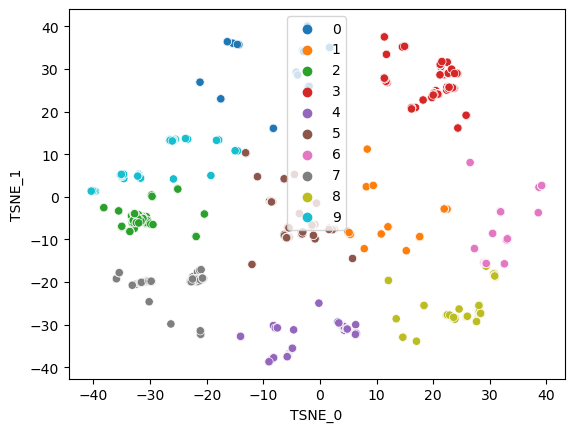

In [99]:
df_tsne_exploit_sugg = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'exploit']
X_tsne_exploit = df_tsne_exploit_sugg.iloc[:,-3:-1]
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_tsne_exploit) ## using # of clusters found by kmeans method
sns.scatterplot(x=df_tsne_exploit_sugg['TSNE_0'], y=df_tsne_exploit_sugg['TSNE_1'], hue=kmeans.labels_, palette='tab10')

In [100]:
# df_tsne_exploit_sugg['norm_capacity_3_avg_pred'] = df_exploit_10000['norm_capacity_3_avg_pred']
df_tsne_exploit_sugg = df_tsne_exploit_sugg.merge(df_exploit_5000[['solv_comb_sm', 'norm_capacity_3_avg_pred']], on='solv_comb_sm', how='left')
df_tsne_exploit_sugg

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred
0,COP(=O)(OC)OP,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.562406,-1.128913,1.184731,-0.439677,-0.025809,-0.102259,0.229179,0.346099,...,186.939685,1.0,0.0,150,50,2,30.916122,-18.803947,exploit,0.287347
1,COCCOF,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.863536,-1.039067,1.081461,-0.406529,-0.227115,0.260969,0.755056,0.576431,...,186.939685,1.0,0.0,150,50,2,20.200350,24.282938,exploit,0.357369
2,COP(C)(=O)O[AlH2],[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.603479,-1.143439,1.165883,-0.352102,0.087478,-0.056811,0.257733,0.317275,...,186.939685,1.0,0.0,150,50,2,-8.869445,-38.642567,exploit,0.291133
3,COP(=O)(P)OP,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.533840,-1.115119,1.176279,-0.414674,-0.057984,-0.106595,0.212265,0.303192,...,186.939685,1.0,0.0,150,50,2,30.914911,-18.829397,exploit,0.283077
4,COP(C)(=O)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.571544,-1.117965,1.153550,-0.344366,0.030375,-0.090227,0.187540,0.329235,...,186.939685,1.0,0.0,150,50,2,30.952755,-18.879631,exploit,0.281960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CCC(COC)OP(C)(C)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.239619,-1.228690,0.668977,-0.171034,-0.931992,-0.098993,0.479596,0.338190,...,186.939685,1.0,0.0,150,50,2,-1.396687,-6.646124,exploit,0.308698
4996,COCCP(=O)(CCOC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.805967,-1.115955,1.119376,-0.389826,-0.320216,0.289752,0.666986,0.669284,...,186.939685,1.0,0.0,150,50,2,20.000217,23.863493,exploit,0.321026
4997,FCCOCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.645508,-1.686106,0.770590,-0.476692,0.716019,-0.145151,0.818991,0.095029,...,186.939685,1.0,0.0,150,50,2,21.531021,31.725594,exploit,0.312907
4998,COCOCOP=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.599196,-0.969392,0.889094,-0.231780,-0.288586,0.057383,0.397675,0.209634,...,186.939685,1.0,0.0,150,50,2,-9.002964,-38.695023,exploit,0.288703


In [101]:
row_label = df_tsne_exploit.loc[df_tsne_exploit['database'] == 'label']
df_tsne_exploit_sugg['database'] = [('exploit_' + str(kmeans.labels_.astype(str)[i])) for i in range(len(kmeans.labels_))]
df_tsne_exploit_ = pd.concat([row_label, df_tsne_exploit_sugg], axis=0)
df_tsne_exploit_

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,mol_wt_salt,conc_salt_1,conc_salt_2,theor_capacity,amt_electrolyte,pressure_type,TSNE_0,TSNE_1,database,norm_capacity_3_avg_pred
1050,CO[Si](CCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F)C(...,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.703865,-1.378061,0.988412,-0.661167,0.540599,-0.224957,0.849146,-0.022704,...,186.939685,1.0,0.0,150,50,2,14.868960,35.267883,label,NaN
2373,CN1CCCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,1.389185,-0.935876,0.111029,0.485331,0.308117,-0.724181,0.398491,0.687894,...,186.939685,1.0,0.0,150,50,2,26.357819,-1.480546,label,NaN
4139,CCN1CCCC1,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,0.876502,-1.072168,-0.081963,0.736596,0.206000,-0.486059,0.263508,0.370727,...,186.939685,1.0,0.0,150,50,2,-27.672503,6.123165,label,NaN
5684,CCCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.185937,-1.761041,0.562131,0.697612,-0.655805,1.009843,0.605023,0.421360,...,186.939685,1.0,0.0,150,50,2,-3.126033,34.261627,label,NaN
6664,CCCOC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.937292,-1.613544,0.672441,0.163123,-0.543020,0.617387,0.624449,0.415481,...,186.939685,1.0,0.0,150,50,2,-14.375510,35.692364,label,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CCC(COC)OP(C)(C)=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-1.239619,-1.228690,0.668977,-0.171034,-0.931992,-0.098993,0.479596,0.338190,...,186.939685,1.0,0.0,150,50,2,-1.396687,-6.646124,exploit_5,0.308698
4996,COCCP(=O)(CCOC)OC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.805967,-1.115955,1.119376,-0.389826,-0.320216,0.289752,0.666986,0.669284,...,186.939685,1.0,0.0,150,50,2,20.000217,23.863493,exploit_3,0.321026
4997,FCCOCC(F)(F)C(F)(F)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.645508,-1.686106,0.770590,-0.476692,0.716019,-0.145151,0.818991,0.095029,...,186.939685,1.0,0.0,150,50,2,21.531021,31.725594,exploit_3,0.312907
4998,COCOCOP=O,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.599196,-0.969392,0.889094,-0.231780,-0.288586,0.057383,0.397675,0.209634,...,186.939685,1.0,0.0,150,50,2,-9.002964,-38.695023,exploit_4,0.288703


In [102]:
df_tsne_exploit_['norm_capacity_3_avg_pred']

1050         NaN
2373         NaN
4139         NaN
5684         NaN
6664         NaN
          ...   
4995    0.308698
4996    0.321026
4997    0.312907
4998    0.288703
4999    0.281661
Name: norm_capacity_3_avg_pred, Length: 5119, dtype: float64

In [103]:
df_tsne_exploit_.to_csv('iter_5_top5000_sugg_ei_unique_exploit.csv')

In [104]:
df_tsne_exploit_['database'].unique()

array(['label', 'exploit_8', 'exploit_3', 'exploit_4', 'exploit_2',
       'exploit_6', 'exploit_5', 'exploit_0', 'exploit_7', 'exploit_9',
       'exploit_1'], dtype=object)

In [105]:
def _prepareMol(mol,kekulize):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    return mc

def moltosvg(mol,molSize=(250,100),kekulize=True,drawer=None,**kwargs):
    mc = _prepareMol(mol,kekulize)
    if drawer is None:
        drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.DrawMolecule(mc,**kwargs)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    return SVG(svg.replace('svg:',''))

PandasTools.AddMoleculeColumnToFrame(df_tsne_exploit_,'solv_comb_sm', 'solv')

svgs_solv = [moltosvg(m).data for m in df_tsne_exploit_.solv]
smile = df_tsne_exploit_['solv_comb_sm'].values.tolist()
database_class = df_tsne_exploit_['database'].values.tolist()
ind = df_tsne_exploit_.index.values.tolist()
pred = ([0.0]*110) + [round(val, 3) for val in df_tsne_exploit_['norm_capacity_3_avg_pred'].iloc[110:].values.tolist()]
ChangeMoleculeRendering(renderer='PNG')

# source = ColumnDataSource(data=dict(x=df_comb_tsne__['TSNE_0'], y=df_comb_tsne__['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, color_column_name=df_comb_tsne__['database']))
source = ColumnDataSource(data=dict(x=df_tsne_exploit_['TSNE_0'], y=df_tsne_exploit_['TSNE_1'], svgs_solv=svgs_solv, desc=database_class, smile=smile, ind=ind, pred=pred, color=df_tsne_exploit_['database'].map({'exploit_0':'cyan', 'exploit_1':'orange', 'exploit_2':'gray',
                                                                                                                                                                                       'exploit_3':'teal', 'exploit_4':'green', 'exploit_5':'yellow', 
                                                                                                                                                                                       'exploit_6':'red', 'exploit_7':'purple', 'exploit_8':'lime',
                                                                                                                                                                                       'exploit_9':'magenta', 'label':'blue'})))

hover = HoverTool(tooltips="""
    <div>
        <div> 
            <span style="font-size: 12px; font-weight: bold;"> @svgs_solv{safe} </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> SMILES: @smile </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Class: @desc </span>
        </div>
        <div>
            <span style="font-size: 12px; font-weight: bold;"> Prediction: @pred </span>
        </div>
    </div>
    """
)

interactive_map = figure(width=1000, height=1000, tools=['reset,box_zoom,wheel_zoom,zoom_in,zoom_out,pan',hover])
interactive_map.title.text = "Suggestions from AL (iteration-4; Top 10000 predictions)"
interactive_map.title.align = "center"
interactive_map.title.text_color = "orange"
interactive_map.title.text_font_size = "25px"

# palette = d3['Category10'][len(df_comb_tsne['database'].unique())]
# color_map = CategoricalColorMapper(factors=df_comb_tsne['database'].unique(),
#                                    palette=palette)
# # interactive_map.circle('x', 'y', hue=, size=6, source=source, fill_alpha=0.2)
# # interactive_map.circle('x', 'y', line_color=mapper, color=mapper, size=6, source=source, fill_alpha=0.2)
# # color_bar = ColorBar(color_mapper=mapper['transform'], width=8)
# # interactive_map.add_layout(color_bar, 'right')
interactive_map.scatter('x', 'y', 
                        # color={'field': df_comb_tsne_['database'], 'transform': color_map},
                        color = 'color',
                        # legend='top_right', ## does not work
                        source=source, size=7, fill_alpha=0.8)
output_file("interactive_map_sugg_al_031424_exploit.html")
save(interactive_map)

'/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/AL-CE/08-22-23/campaign-5/interactive_map_sugg_al_031424_exploit.html'